In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [7]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/')

from Dataset_Creation import sys_dataset
import Dataset_load

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : FaXTJBJP 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

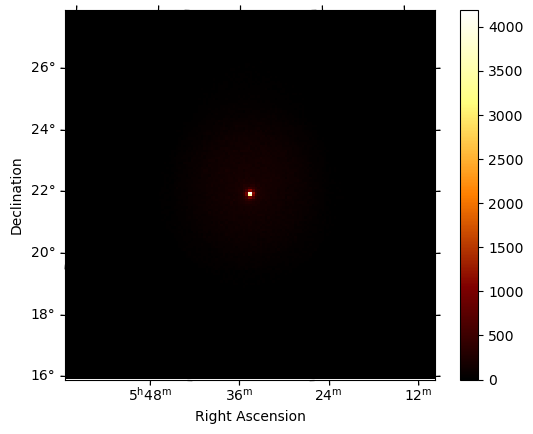

In [4]:
dataset_asimov = Dataset_load.create_asimov()

## Single Cases

In [5]:
bias = 0.1
sigma = 0

def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/b**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

dataset, dataset_N , _ = create_dataset(bias, sigma)

In [10]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(dataset)


CPU times: user 7.74 s, sys: 73 ms, total: 7.81 s
Wall time: 7.82 s


In [11]:
%%time
fit_N = Fit(store_trace=False)
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run(dataset_N)


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: i

CPU times: user 9min 33s, sys: 15min 52s, total: 25min 25s
Wall time: 5min 2s


## Correlation

In [12]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    #parameters = Parameters.from_stack([datasets_compute.models.parameters])
    parameters = datasets_compute.models.parameters
    parameters = parameters.free_parameters

    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

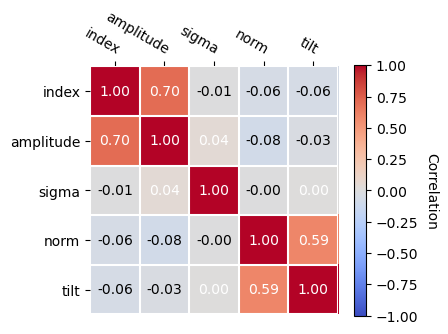

In [13]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

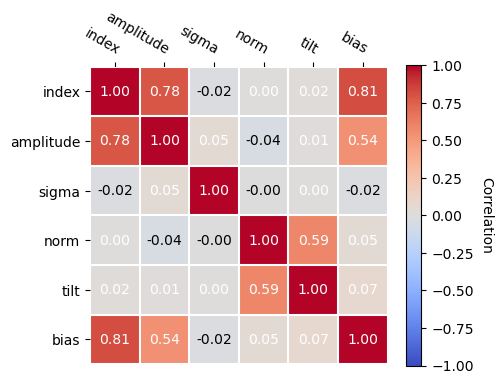

In [14]:
covariance_N  = covariance_(fit_N, dataset_N)
covariance_N.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [15]:
(dataset_N.models.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str12,str10,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3349e+00,,1.113e-01,nan,nan,False,False,False,
spectral,amplitude,1.0300e-12,cm-2 s-1 TeV-1,1.108e-13,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,2.0145e-02,deg,1.300e-02,0.000e+00,nan,False,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,
spectral,norm,1.0001e+00,,2.068e-03,nan,nan,False,True,False,


In [16]:
(dataset.models.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3785e+00,,6.727e-02,nan,nan,False,False,False,
spectral,amplitude,1.0600e-12,cm-2 s-1 TeV-1,9.555e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,1.8951e-02,deg,1.091e-02,0.000e+00,nan,False,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,
spectral,norm,1.0001e+00,,2.066e-03,nan,nan,False,True,False,
